*Nombre de Grupos*: Grupo 1

*Integrantes*:
- Jorge Cevasco
- Martina Ranieri
- Ramiro Padilla

# **Laboratorio 3: Mean Shift**

El algoritmo **Mean Shift** es una técnica iterativa de agrupamiento (***clustering***) que se utiliza ampliamente en visión por computadora, especialmente en tareas como segmentación de imágenes y seguimiento de objetos. A diferencia de métodos como K-Means, Mean Shift no requiere especificar de antemano el número de clusters, lo que lo convierte en una herramienta poderosa para analizar datos con formas arbitrarias o estructuras complejas.

## **¿Cómo funciona?**

Mean Shift busca las "modas" o máximos locales de una distribución de probabilidad. En el contexto de visión por computadora, estas modas pueden corresponder a regiones homogéneas en una imagen, como objetos o partes de un objeto con color o textura similares.

El procedimiento consiste en:

1. Inicializar cada punto como un centroide de Cluster.
2. Repetir los siguientes pasos hastas lograr convergencia o una cantidad maxima de iteraciones:
  1. Por cada punto, calculamos el promedio de todos los puntos en un radio (kernel) centrado en el punto.
  2. Movemos el punto hacia el promedio.
3. Identificamos a los centroides como los puntos que no se movieron luego de converger.
4. Fusionamos los centroides cercanos.

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy.random import choice
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import distance_matrix
import random
from skimage import data, transform, io, util


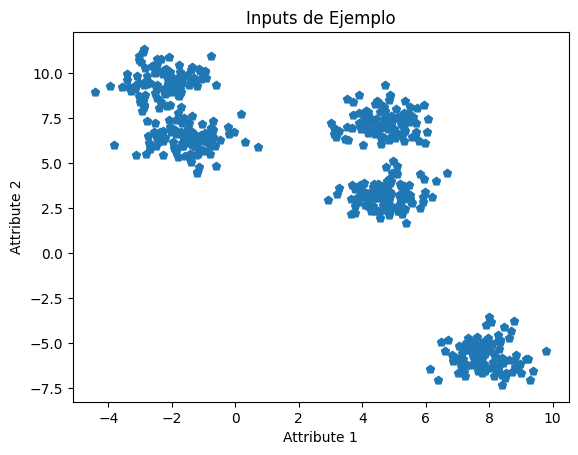

In [ ]:
# Creamos un dataset de prueba
X, _ = make_blobs(n_samples=500, centers=5, cluster_std=0.7, random_state=27)

# Como bandwidth, utilizamos el cuantil 0.2 de las distancias entre cada punto
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

plt.scatter(X[:, 0], X[:, 1], marker='p')
plt.title('Inputs de Ejemplo')
plt.xlabel('Attribute 1')
plt.ylabel('Attribute 2')
plt.show()

## **KDE**

Mean Shift se basa en el concepto de estimación de densidad por núcleos, conocido como KDE (por sus siglas en inglés, Kernel Density Estimation). Imagina que los datos que observamos fueron muestreados a partir de una distribución de probabilidad. La estimación KDE es un método para estimar la distribución subyacente de los datos, también llamada función de densidad de probabilidad.

Al sumar todos los kernels individuales, se genera una superficie de densidad que representa la distribución estimada de los datos. Dependiendo del valor del parámetro (bandwidth) utilizado, la forma de la función de densidad resultante puede variar significativamente.

$$\hat{f}(\mathbf{x}) = \sum_{i=1}^{n} K\left( \frac{\| \mathbf{x} - \mathbf{x}_i \|}{h} \right)$$

In [ ]:
# Kernel Gaussiano
def kernel(distance, bandwidth):
    return np.exp(-0.5 * (distance / bandwidth) ** 2)

# KDE
# Sumamos cada uno de los kernel individuales
def kde(grid_x, grid_y, data_points, bandwidth):
    Z = np.zeros_like(grid_x)
    for point in data_points:
        dist = np.sqrt((grid_x - point[0])**2 + (grid_y - point[1])**2)
        Z += kernel(dist, bandwidth)
    return Z


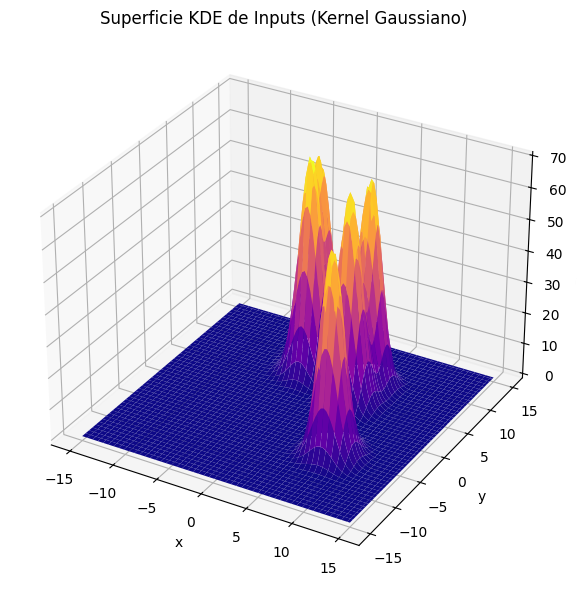

In [ ]:

x = np.linspace(-15, 15, 100)
y = np.linspace(-15, 15, 100)
Xgrid, Ygrid = np.meshgrid(x, y)

bandwidth = 1.0 # JUEGUEN CON LOS DIFERENTES VALORES DE BANDWIDTH
Z = kde(Xgrid, Ygrid, X, bandwidth)

# Ploteamos la KDE
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xgrid, Ygrid, Z, cmap='plasma', edgecolor='none')
ax.set_title('Superficie KDE de Inputs (Kernel Gaussiano)')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Density')
plt.tight_layout()
plt.show()

## Implementacion

Para calcular el desplazamiento de los puntos, tendremos que calcular su vector de desplazamiento, un promedio pesado segun el kernel y la distacia del resto de los elementos en el conjunto.

$$\mathbf{m}(\mathbf{x}_i) = \frac{ \sum\limits_{j=1}^{n} \mathbf{x}_j \cdot K\left( \left\| \frac{\mathbf{x}_i - \mathbf{x}_j}{h} \right\|^2 \right) }{ \sum\limits_{j=1}^{n} K\left( \left\| \frac{\mathbf{x}_i - \mathbf{x}_j}{h} \right\|^2 \right) } - \mathbf{x}_i$$

- $m$($x_i$​): el vector de desplazamiento que se aplica a cada punto $x_i$

- $x_j$​: puntos vecinos

- $h$: ancho de banda (bandwidth)

- $K$(⋅): función kernel (ej. Gaussiana)

- ∥⋅∥: norma euclidiana





In [ ]:
def shift(p, original_points, kernel_bandwidth):
  """
    p: El punto a calcular su desplazamiento
    Original_points: Los puntos originales dados en el input
    kernel_bandwidth: bandwidth a utilizar

    return: La nueva ubicacion del punto.
  """
  shift_vector = np.zeros_like(p)
  scale_factor = 0

  # Calculamos el promedio pesado de cada uno de los puntos
  for p_temp in original_points:
    # numerador
    dist = norm(p - p_temp)
    scale_factor = kernel(dist, kernel_bandwidth)
    shift_vector += p_temp*scale_factor

  # denominador
  z = kde(p[0], p[1], original_points, kernel_bandwidth )
  shift_vector = (shift_vector / z)

  return shift_vector

In [ ]:
def mean_shift(points, bandwidth=2.0, max_iter=300, tolerance=1e-3):

  # Hacemos una copia de los puntos originales para ir shiftenado
  points = np.array(points)
  shifted_points = np.copy(points)

  # Guardamos algunos puntos para plotear
  randomIndexs = random.sample(range(1, len(points)), k=2)
  shifted_points_hist = [np.copy(shifted_points[randomIndexs])]

  # Por cada iteracion, shifteamos los numeros y verificamos si ya logramos el
  # criterio de convergencia
  # Maximo Shifteo < tolerance
  for it in range(max_iter):
    max_shift_distance = 0.0
    for i in range(len(shifted_points)):
      # por cada punto, actualizamos su posicion calculando su shifteo
      # Guardamos la magnitud del cambio
      # Verificamos si es el mayor cambio que hubo
      shifted_tmp = np.copy(shifted_points[i])

      shifted_points[i] = shift(shifted_points[i], points, bandwidth)
      magnitud = norm(shifted_points[i] - shifted_tmp)
      max_shift_distance = max(max_shift_distance, magnitud)

    shifted_points_hist.append(np.copy(shifted_points[randomIndexs]))

    print(f"Iteracion {it+1}")
    if max_shift_distance < tolerance:
      print("Convergencia")
      print()
      break

  # Filtramos los centroides y asignamos cada punto a un cluster
  centroids = []
  labels = np.full(len(shifted_points), -1)

  for i, point in enumerate(shifted_points):
    assigned = False
    for cid, centroid in enumerate(centroids):
      if np.linalg.norm(point - centroid) < bandwidth:
        labels[i] = cid
        assigned = True
        break

    if not assigned:
      centroids.append(point)
      labels[i] = len(centroids) - 1

  centroids = np.array(centroids)
  return labels, centroids, shifted_points_hist

Iteracion 1
Iteracion 2
Iteracion 3
Iteracion 4
Iteracion 5
Iteracion 6
Iteracion 7
Iteracion 8
Iteracion 9
Iteracion 10
Iteracion 11
Iteracion 12
Iteracion 13
Iteracion 14
Iteracion 15
Iteracion 16
Iteracion 17
Iteracion 18
Iteracion 19
Iteracion 20
Iteracion 21
Iteracion 22
Iteracion 23
Iteracion 24
Iteracion 25
Iteracion 26
Iteracion 27
Iteracion 28
Iteracion 29
Iteracion 30
Iteracion 31
Iteracion 32
Iteracion 33
Iteracion 34
Iteracion 35
Iteracion 36
Convergencia



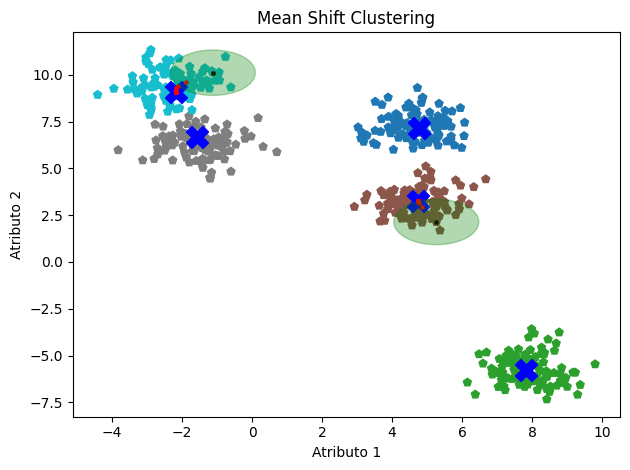

In [ ]:

# Estimamos el bandwith optimo
bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=500)

# Creamos los clusters
labels, centroids, hist = mean_shift(X,bandwidth)

fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', marker='p')
ax.scatter(centroids[:, 0], centroids[:, 1], s=250, c='blue', marker='X')

for iteracion in hist:
    ax.scatter(iteracion[:, 0], iteracion[:, 1], s=5, c='red', marker='X')

for point in hist[0]:
    ax.scatter(*point, s=5, c='black', marker='X')
    circle = plt.Circle(point, radius=bandwidth, color='green', alpha=0.3, label='Bandwidth')
    ax.add_patch(circle)

ax.set_title('Mean Shift Clustering')
ax.set_xlabel('Atributo 1')
ax.set_ylabel('Atributo 2')
plt.tight_layout()
plt.show()


## **Comparacion con Scikit Learn**

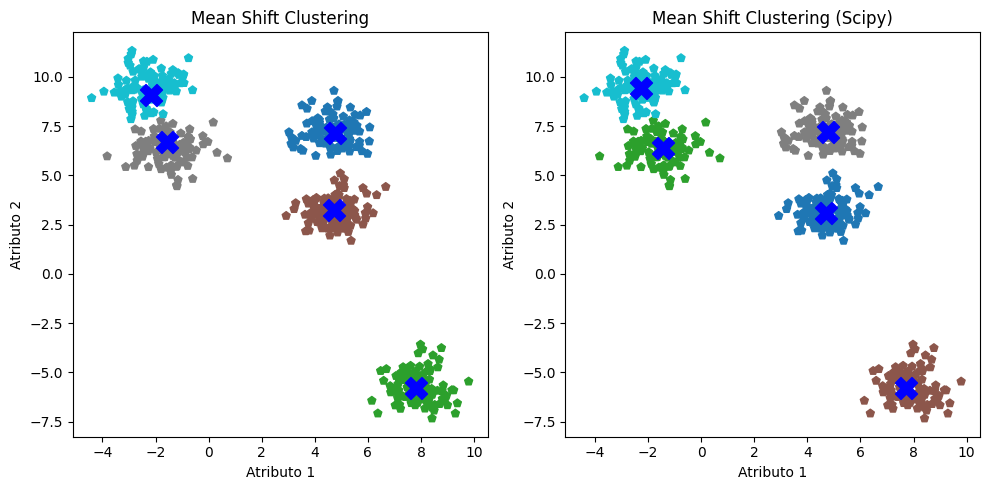

In [ ]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
scipy_centers = ms.cluster_centers_
scipy_labels = ms.labels_


# Create a figure and axes object

fig, ax = plt.subplots(1,2,figsize=(10,5))


# Plot everything using ax instead of plt
ax[0].scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', marker='p')
ax[0].scatter(centroids[:, 0], centroids[:, 1], s=250, c='blue', marker='X')
ax[0].set_title('Mean Shift Clustering')
ax[0].set_xlabel('Atributo 1')
ax[0].set_ylabel('Atributo 2')

ax[1].scatter(X[:, 0], X[:, 1], c=scipy_labels, cmap='tab10', marker='p')
ax[1].scatter(scipy_centers[:, 0], scipy_centers[:, 1], s=250, c='blue', marker='X')
ax[1].set_title('Mean Shift Clustering (Scipy)')
ax[1].set_xlabel('Atributo 1')
ax[1].set_ylabel('Atributo 2')

plt.tight_layout()
plt.show()

## **Segmentacion de una Imagen**

(10000, 2)


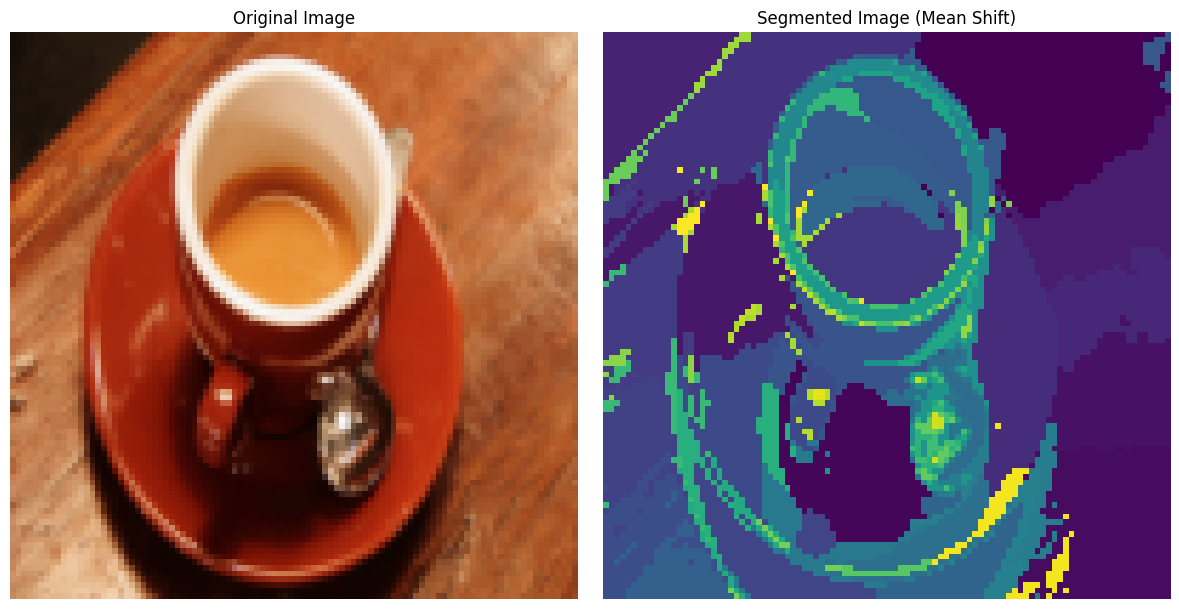

In [ ]:

# Cargamos y achicamos la imagen para que no sea lenta de correr
image = util.img_as_float(data.coffee())  # o data.astronaut()
image = transform.resize(image, (100, 100), anti_aliasing=True)
h, w, c = image.shape

# Creamos los vectores de input: [R, G, B, x, y]
X_coords, Y_coords = np.meshgrid(np.arange(w), np.arange(h))
features = np.concatenate((
    image.reshape(-1, 3),                    # valores RGB
    X_coords.reshape(-1, 1),                 # posicion X
    Y_coords.reshape(-1, 1)                  # posicion Y
), axis=1)

# Normalizamos las coordenadas para que matcheen con el rango de valores de rgb
features[:, 3:] /= np.max([h, w])
# Encontramos los segmentos
bandwidth = estimate_bandwidth(features[:, 3:], quantile=0.05, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(features)
labels = ms.labels_


labels = labels.reshape(h, w)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title('Original Image')
ax[1].imshow(labels)
ax[1].set_title('Segmented Image (Mean Shift)')
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()